# Q2

## Part A: Minimum Probability of Error Classification (0-1 Loss)

In [2]:
## Step 1: Generate 10,000 Samples from the Data Distribution
import numpy as np

# Class priors
P_L1 = 0.3
P_L2 = 0.3
P_L3 = 0.4

# Means and covariances for each class
mean_1 = [0, 0, 0]  # Mean for class 1
mean_2 = [3, 3, 3]  # Mean for class 2
mean_3a = [6, 0, 0]  # First component of class 3
mean_3b = [0, 6, 6]  # Second component of class 3

cov_1 = np.eye(3)  # Covariance for class 1 (identity)
cov_2 = np.eye(3)  # Covariance for class 2 (identity)
cov_3 = np.eye(3)  # Same covariance for both components of class 3

# Number of samples to generate
n_samples = 10000

# Generate samples for each class based on the priors
n_L1 = int(P_L1 * n_samples)
n_L2 = int(P_L2 * n_samples)
n_L3 = n_samples - n_L1 - n_L2

# Generate class 1 samples (single Gaussian)
samples_L1 = np.random.multivariate_normal(mean_1, cov_1, n_L1)

# Generate class 2 samples (single Gaussian)
samples_L2 = np.random.multivariate_normal(mean_2, cov_2, n_L2)

# Generate class 3 samples (from mixture of two Gaussians)
samples_L3a = np.random.multivariate_normal(mean_3a, cov_3, n_L3 // 2)
samples_L3b = np.random.multivariate_normal(mean_3b, cov_3, n_L3 // 2)
samples_L3 = np.vstack((samples_L3a, samples_L3b))

# Combine samples and create true labels
samples = np.vstack((samples_L1, samples_L2, samples_L3))
labels = np.array([1] * n_L1 + [2] * n_L2 + [3] * n_L3)

# Print shapes to verify
print(f"Generated samples shape: {samples.shape}")
print(f"Generated labels shape: {labels.shape}")


Generated samples shape: (10000, 3)
Generated labels shape: (10000,)


In [3]:
## Step 2: Implement the Bayesian Decision Rule (Minimum Error)
from scipy.stats import multivariate_normal

# Compute the class-conditional likelihoods for each class
likelihood_L1 = multivariate_normal.pdf(samples, mean=mean_1, cov=cov_1)
likelihood_L2 = multivariate_normal.pdf(samples, mean=mean_2, cov=cov_2)
likelihood_L3a = multivariate_normal.pdf(samples, mean=mean_3a, cov=cov_3)
likelihood_L3b = multivariate_normal.pdf(samples, mean=mean_3b, cov=cov_3)

# Class 3 is a mixture, so we average the likelihoods from the two components
likelihood_L3 = 0.5 * (likelihood_L3a + likelihood_L3b)

# Compute the posterior probabilities using Bayes' Rule
posterior_L1 = likelihood_L1 * P_L1
posterior_L2 = likelihood_L2 * P_L2
posterior_L3 = likelihood_L3 * P_L3

# Combine posteriors into a matrix
posteriors = np.vstack((posterior_L1, posterior_L2, posterior_L3)).T

# Classify based on maximum posterior probability (Bayesian Decision Rule)
predicted_labels = np.argmax(posteriors, axis=1) + 1  # Add 1 to match label indexing

# Calculate the confusion matrix
confusion_matrix = np.zeros((3, 3), dtype=int)

for true_label, predicted_label in zip(labels, predicted_labels):
    confusion_matrix[true_label - 1, predicted_label - 1] += 1

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)


Confusion Matrix:
[[2983   13    4]
 [  17 2960   23]
 [   3   19 3978]]


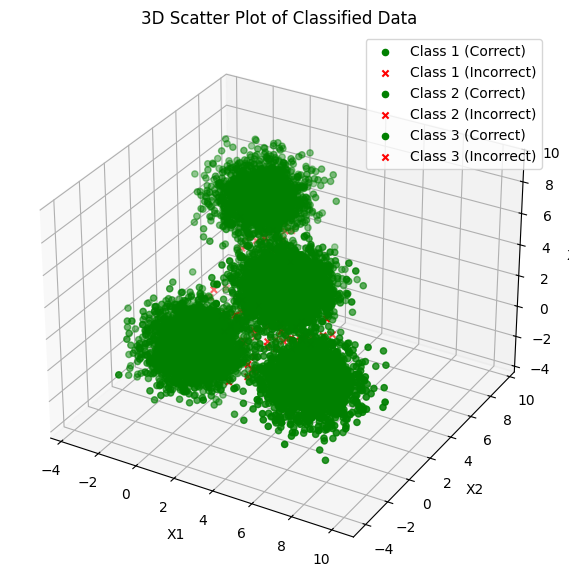

In [5]:
## Step 3: Visualize the Data in 3D and Indicate Correct/Incorrect Classifications

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot of the data
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Correctly classified points will be green, incorrect ones will be red
for i in range(1, 4):
    correct_idx = (labels == i) & (predicted_labels == i)
    incorrect_idx = (labels == i) & (predicted_labels != i)

    ax.scatter(samples[correct_idx, 0], samples[correct_idx, 1], samples[correct_idx, 2], label=f'Class {i} (Correct)', marker='o', color='green', s=20)
    ax.scatter(samples[incorrect_idx, 0], samples[incorrect_idx, 1], samples[incorrect_idx, 2], label=f'Class {i} (Incorrect)', marker='x', color='red', s=20)

# Labels and title
ax.set_title("3D Scatter Plot of Classified Data")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
ax.legend(loc="best")

# Show the plot
plt.show()


## Part B: Expected Risk Minimization (ERM) with Different Loss Matrices


In [6]:
# Loss matrices
Lambda_10 = np.array([[0, 10, 10],
                      [1, 0, 10],
                      [1, 1, 0]])

Lambda_100 = np.array([[0, 100, 100],
                       [1, 0, 100],
                       [1, 1, 0]])

# Function to compute expected risk
def expected_risk(posterior_probs, loss_matrix):
    return posterior_probs.dot(loss_matrix)

# Perform classification with Lambda_10
risk_10 = expected_risk(posteriors, Lambda_10)
predicted_labels_10 = np.argmin(risk_10, axis=1) + 1

# Perform classification with Lambda_100
risk_100 = expected_risk(posteriors, Lambda_100)
predicted_labels_100 = np.argmin(risk_100, axis=1) + 1

# Calculate and print confusion matrices for both
confusion_matrix_10 = np.zeros((3, 3), dtype=int)
confusion_matrix_100 = np.zeros((3, 3), dtype=int)

for true_label, predicted_label in zip(labels, predicted_labels_10):
    confusion_matrix_10[true_label - 1, predicted_label - 1] += 1

for true_label, predicted_label in zip(labels, predicted_labels_100):
    confusion_matrix_100[true_label - 1, predicted_label - 1] += 1

print("Confusion Matrix (Lambda_10):")
print(confusion_matrix_10)

print("Confusion Matrix (Lambda_100):")
print(confusion_matrix_100)


Confusion Matrix (Lambda_10):
[[2996    4    0]
 [  58 2935    7]
 [   9   61 3930]]
Confusion Matrix (Lambda_100):
[[3000    0    0]
 [ 148 2850    2]
 [  43  167 3790]]


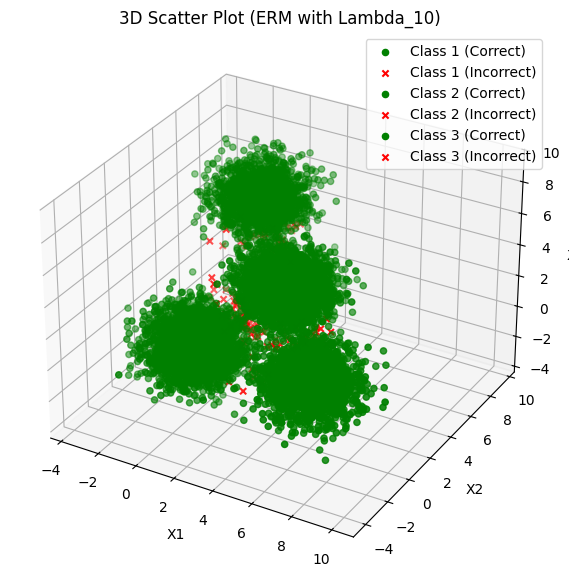

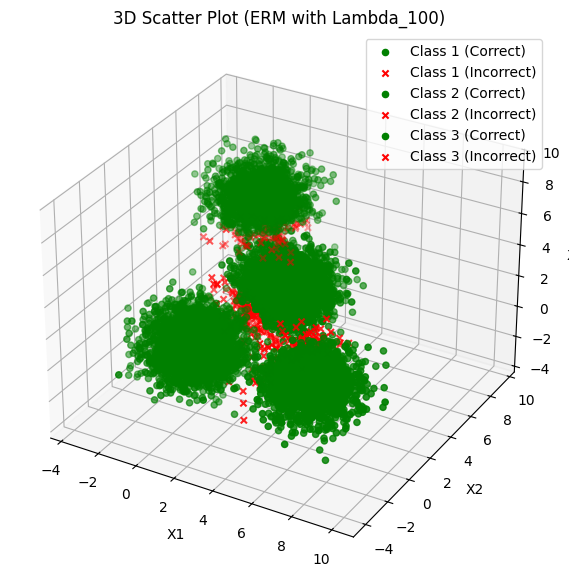

In [7]:
# Function to create the 3D scatter plot
def plot_3d_classification(samples, labels, predicted_labels, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(1, 4):
        correct_idx = (labels == i) & (predicted_labels == i)
        incorrect_idx = (labels == i) & (predicted_labels != i)

        ax.scatter(samples[correct_idx, 0], samples[correct_idx, 1], samples[correct_idx, 2], label=f'Class {i} (Correct)', marker='o', color='green', s=20)
        ax.scatter(samples[incorrect_idx, 0], samples[incorrect_idx, 1], samples[incorrect_idx, 2], label=f'Class {i} (Incorrect)', marker='x', color='red', s=20)

    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    ax.legend(loc="best")
    plt.show()

# Plot for Lambda_10
plot_3d_classification(samples, labels, predicted_labels_10, "3D Scatter Plot (ERM with Lambda_10)")

# Plot for Lambda_100
plot_3d_classification(samples, labels, predicted_labels_100, "3D Scatter Plot (ERM with Lambda_100)")


In [8]:
# Compare Confusion Matrices
print("Comparison of Confusion Matrices:\n")

# Confusion matrix for Bayesian classification (Part A)
print("Confusion Matrix (Bayesian Classifier - Part A):")
print(confusion_matrix)

# Confusion matrix for ERM with Lambda_10
print("\nConfusion Matrix (ERM with Lambda_10):")
print(confusion_matrix_10)

# Confusion matrix for ERM with Lambda_100
print("\nConfusion Matrix (ERM with Lambda_100):")
print(confusion_matrix_100)


Comparison of Confusion Matrices:

Confusion Matrix (Bayesian Classifier - Part A):
[[2983   13    4]
 [  17 2960   23]
 [   3   19 3978]]

Confusion Matrix (ERM with Lambda_10):
[[2996    4    0]
 [  58 2935    7]
 [   9   61 3930]]

Confusion Matrix (ERM with Lambda_100):
[[3000    0    0]
 [ 148 2850    2]
 [  43  167 3790]]


### Inisght

### Summary of Insights:
- **As the penalty for Class 3 errors increases** (from \(\Lambda_{10}\) to \(\Lambda_{100}\)), the model becomes highly accurate in classifying Class 3 but **at the cost of more errors** in Classes 1 and 2.
- **The trade-off** is evident: focusing on reducing errors for one class (Class 3) leads to increased misclassifications for other classes (especially Class 2).
  